## **Подготовка к работе с данными**
Импортируем все необходимые в работе модули:

In [1]:
import copy
import os
import pickle
import shutil
import time
from pathlib import Path

import matplotlib.patches as patches
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image, ImageOps
from efficientnet_pytorch import EfficientNet
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

Проверим доступность CUDA:

In [3]:
!nvidia-smi
print("Cuda status - ", "AVAILABLE" if torch.cuda.is_available() else "NOT AVAILABLE")

Sun Apr 25 07:21:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    40W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

CUDA доступна, будем работать там.
Определим нужные в дальнейшем "константы":

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('test/testset')
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

Посмотрим на распределение train данных:

In [5]:
stats = {}
total_imgs = 0
for folder in TRAIN_DIR.iterdir():
    folder_imgs = len(list(folder.glob("*")))
    stats[folder.name] = folder_imgs
    total_imgs += folder_imgs
for word in sorted(stats, key=stats.get):
    print(
        "{:<30s}{:<15d}{:<.3f}%".format(
            word, stats[word], stats[word] / total_imgs * 100
        )
    )
print('Total files: ', total_imgs)

lionel_hutz                   3              0.014%
troy_mcclure                  8              0.038%
disco_stu                     8              0.038%
miss_hoover                   17             0.081%
fat_tony                      27             0.129%
gil                           27             0.129%
otto_mann                     32             0.153%
sideshow_mel                  40             0.192%
agnes_skinner                 41             0.196%
rainier_wolfcastle            45             0.216%
cletus_spuckler               46             0.220%
snake_jailbird                55             0.263%
professor_john_frink          64             0.307%
martin_prince                 71             0.340%
patty_bouvier                 72             0.345%
ralph_wiggum                  89             0.426%
carl_carlson                  96             0.460%
selma_bouvier                 103            0.493%
barney_gumble                 106            0.508%
groundskeepe

Видно, что классы сильно несбалансированны. 
Решением этой проблемы займемся чуть позже.
Сейчас же создадим обертку для удобной работы с картинками:

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != "test":
            # Создает список имен персонажей
            self.labels = [path.parent.name for path in self.files]
            # Каждому имени присваивается числовой номер
            self.label_encoder.fit(self.labels)

            with open("label_encoder.pkl", "wb") as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        t1 = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(10,scale=(0.7,1.1)),
            ]
        )
        t2 = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        if self.mode == "test":
            x = t2(x)
            return x
        else:
            x = t1(x)
            x = t2(x)
            # Берется имя персонажа как набор символов
            label = self.labels[index]
            # Далее оно преобразуется в массив с числом-идентификатором имени
            label_id = self.label_encoder.transform([label])
            # Из массива извлекается это самое число
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        """
        Масштабирует изображение до размеров RESCALE_SIZE x RESCALE_SIZE сохраняя соотношения сторон
        """
        if max(image.size) > RESCALE_SIZE:
            if image.size[0] > image.size[1]:
                image = image.resize(
                    (RESCALE_SIZE, int(RESCALE_SIZE * image.size[1] / image.size[0]))
                )
            else:
                image = image.resize(
                    (int(RESCALE_SIZE * image.size[0] / image.size[1]), RESCALE_SIZE)
                )

        d_w = RESCALE_SIZE - image.size[0]
        d_h = RESCALE_SIZE - image.size[1]
        padding = (d_w // 2, d_h // 2, d_w - (d_w // 2), d_h - (d_h // 2))
        image = ImageOps.expand(image, padding)
        return image

Фабрика классов (наша обертка) принимает на вход список файлов и режим их обработки.
Займемся файлами; сделаем отсортированные списки путей до персонажей:

In [7]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Разделим список train_val_files на две подвыборки так, чтобы в них количественные отношения между классами
были близки к тому, что имеется в исходном наборе данных:

In [8]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(
    train_val_files, test_size=0.25, stratify=train_val_labels
)

На всякий случай проверим что именно и в каких количествах попало в train_files:

In [9]:
word, count = np.unique(
    np.array([path.parent.name for path in train_files]), return_counts=True
)
total_imgs = np.array(count).sum()

count, word = map(list, zip(*sorted(zip(count, word))))
for index, value in enumerate(count):
    print("{:<30s}{:<15d}{:<.3f}%".format(word[index], value, value / total_imgs * 100))
print('Total files: ', total_imgs)

weights_train = []
word1, count1 = map(list, zip(*sorted(zip(word, count))))
for value in count1:
    weights_train += [1.0/value]*value
weights_train = torch.DoubleTensor(weights_train)

lionel_hutz                   2              0.013%
disco_stu                     6              0.038%
troy_mcclure                  6              0.038%
miss_hoover                   13             0.083%
fat_tony                      20             0.128%
gil                           20             0.128%
otto_mann                     24             0.153%
sideshow_mel                  30             0.192%
agnes_skinner                 31             0.198%
rainier_wolfcastle            34             0.217%
cletus_spuckler               35             0.224%
snake_jailbird                41             0.262%
professor_john_frink          48             0.307%
martin_prince                 53             0.339%
patty_bouvier                 54             0.345%
ralph_wiggum                  67             0.428%
carl_carlson                  72             0.460%
selma_bouvier                 77             0.492%
barney_gumble                 80             0.511%
groundskeepe

Можно заметить, что в данном блоке помимо всего прочего были посчитаны модифицированные веса
для дальнейшего использования в WeightedRandomSampler для борьбы с дисбалансом классов.
Аналогичным образом исследуем val_files:

In [10]:
word, count = np.unique(
    np.array([path.parent.name for path in val_files]), return_counts=True
)
total_imgs = np.array(count).sum()

count, word = map(list, zip(*sorted(zip(count, word))))
for index, value in enumerate(count):
    print("{:<30s}{:<15d}{:<.3f}%".format(word[index], value, value / total_imgs * 100))
print('Total files: ', total_imgs)

word1, count1 = map(list, zip(*sorted(zip(word, count))))
weights_val = []
for value in count1:
    weights_val += [1.0/value]*value
weights_val = torch.DoubleTensor(weights_val)

lionel_hutz                   1              0.019%
disco_stu                     2              0.038%
troy_mcclure                  2              0.038%
miss_hoover                   4              0.077%
fat_tony                      7              0.134%
gil                           7              0.134%
otto_mann                     8              0.153%
agnes_skinner                 10             0.192%
sideshow_mel                  10             0.192%
cletus_spuckler               11             0.211%
rainier_wolfcastle            11             0.211%
snake_jailbird                14             0.268%
professor_john_frink          16             0.307%
martin_prince                 18             0.345%
patty_bouvier                 18             0.345%
ralph_wiggum                  22             0.422%
carl_carlson                  24             0.460%
barney_gumble                 26             0.498%
selma_bouvier                 26             0.498%
groundskeepe

Видно что % соотношения у train_val_files (т.е. всего train датасета) и подвыборках примерно одинаковы, на что мы и рассчитывали.
При этом картинки в разбиениях не повторяются.
Теперь, когда списки файлов готовы, можно задействовать обертку:

In [11]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

## **Подготовка модели и ее обучение**
Для классификации будем использовать EfficientNet.
Но перед тем как делать что-либо, создадим пару вспомогательных функций:

In [12]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=20):
    since = time.time()
    history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataloaders[phase].sampler.num_samples
            epoch_acc = running_corrects.double() / dataloaders[phase].sampler.num_samples

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_loss = epoch_loss
                train_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc

        history.append((train_loss, train_acc, val_loss, val_acc))
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history


def predict(model, test_loader):
    """
    Предсказывает вероятности принадлежности классам элементов данного DataLoader'а
    """
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Теперь инициализируем саму модель, попутно добавив в нее линейный слой подходящий под нашу задачу
(т.е. с числом выходов равным числу персонажей):

In [13]:
num_classes = len(stats)
batch_size = 64
num_epochs = 25

model_ft = EfficientNet.from_pretrained('efficientnet-b2', num_classes=num_classes)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, num_classes)

Loaded pretrained weights for efficientnet-b2


Загруженная EfficientNet уже обучена на ImageNet.
Посмотрим на ее внутреннее устройство и все параметры:

In [14]:
end_number = len(list(model_ft.parameters()))
def print_model_params(model, curr_depth=1):
    global end_number
    for child in model.children():
        print("-" * 2 * curr_depth, str(child).split("(")[0])
        for key in child._parameters.keys():
            if key == "bias" and child.bias is None:
                pass
            else:
                print("-" * 3 * curr_depth, "p:", end_number, key)
                end_number -= 1
        if child._modules:
            print_model_params(child, curr_depth=curr_depth + 1)


print_model_params(model_ft)

-- Conv2dStaticSamePadding
--- p: 301 weight
---- ZeroPad2d
-- BatchNorm2d
--- p: 300 weight
--- p: 299 bias
-- ModuleList
---- MBConvBlock
------ Conv2dStaticSamePadding
--------- p: 298 weight
-------- ZeroPad2d
------ BatchNorm2d
--------- p: 297 weight
--------- p: 296 bias
------ Conv2dStaticSamePadding
--------- p: 295 weight
--------- p: 294 bias
-------- Identity
------ Conv2dStaticSamePadding
--------- p: 293 weight
--------- p: 292 bias
-------- Identity
------ Conv2dStaticSamePadding
--------- p: 291 weight
-------- Identity
------ BatchNorm2d
--------- p: 290 weight
--------- p: 289 bias
------ MemoryEfficientSwish
---- MBConvBlock
------ Conv2dStaticSamePadding
--------- p: 288 weight
-------- ZeroPad2d
------ BatchNorm2d
--------- p: 287 weight
--------- p: 286 bias
------ Conv2dStaticSamePadding
--------- p: 285 weight
--------- p: 284 bias
-------- Identity
------ Conv2dStaticSamePadding
--------- p: 283 weight
--------- p: 282 bias
-------- Identity
------ Conv2dStatic

Рядом с каждым параметром написан его номер при отсчете с конца. Это сделано для удобства, так легче понять какое число
следует подавать в определенную ниже функцию, контролирующую состояние (изменяемые или нет) всех весов и смещений модели:

In [15]:
def modify_params_state(model, unlocked_params):
    if unlocked_params == 0:
        unlocked_params = None
    for param in [*model_ft.parameters()][:-unlocked_params]:
        param.requires_grad = False


# Кол-во параметров сети (с конца), которые могут меняться по мере обучения
# Обучим все
unlocked_params = len(list(model_ft.parameters()))
modify_params_state(model_ft, unlocked_params)

Теперь нужно определить, как именно из общего объема обучающих данных будут выбираться картинки.
Из-за несбалансированности классов делать это нужно особым образом, каждый раз искусственно увеличивая шансы взять персонажей с небольшим
числом изображений, что с точки зрения сети создаст иллюзию работы со сбалансированным датасетом.
Для этих целей и существует функция WeightedRandomSampler().
Именованный аргумент replacement контролирует, выбирать картинки с возвратом или без, т.е. можно ли переизбирать одни и те же объекты. В нашем случае это жизненно необходимо.
Также есть параметр num_samples, который был удвоен для того, чтобы большее число разных картинок из доминирующих классов попало в сеть (тех же результатов, в теории, можно добиться и увеличением числа эпох).

Итого:

In [16]:
wtrain_sampler = WeightedRandomSampler(
    weights=weights_train, num_samples=2*len(weights_train), replacement=True
)
wval_sampler = WeightedRandomSampler(
    weights=weights_val, num_samples=2*len(weights_val), replacement=True
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, sampler=wtrain_sampler
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, sampler=wval_sampler
)

dataloaders_dict = {"train": train_loader, "val": val_loader}

Посмотрим что дают наши загрузчики данных:

In [17]:
label_encoder = pickle.load(open("label_encoder.pkl", "rb"))
stop = 7
class_labels = [*label_encoder.classes_]
batch_info = {i: [] for i in class_labels}
for number, (file, label) in enumerate(train_loader):
    for index, name in enumerate(class_labels):
        batch_info[name] += [int((label == index).sum())]
    if stop == number:
        break
train_df = pd.DataFrame.from_dict(batch_info).T

batch_info = {i: [] for i in class_labels}
for number, (file, label) in enumerate(val_loader):
    for index, name in enumerate(class_labels):
        batch_info[name] += [int((label == index).sum())]
    if stop == number:
        break
val_df = pd.DataFrame.from_dict(batch_info).T

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print('Train batches', '-'*50)
  print(train_df)
  print('Val batches', '-'*50)
  print(val_df)

Train batches --------------------------------------------------
                          0  1  2  3  4  5  6  7
abraham_grampa_simpson    2  3  2  2  0  1  2  2
agnes_skinner             3  4  0  1  0  0  0  2
apu_nahasapeemapetilon    1  1  2  0  2  1  3  0
barney_gumble             0  0  3  3  0  1  2  3
bart_simpson              4  1  1  0  4  4  3  1
carl_carlson              0  0  1  2  1  1  2  0
charles_montgomery_burns  1  2  2  3  1  2  1  1
chief_wiggum              1  3  2  0  2  4  3  1
cletus_spuckler           0  0  1  2  2  3  3  2
comic_book_guy            1  1  2  7  1  1  1  2
disco_stu                 3  1  0  0  1  2  3  3
edna_krabappel            1  1  2  2  1  2  1  2
fat_tony                  0  2  4  1  2  0  3  0
gil                       6  0  2  2  0  3  0  0
groundskeeper_willie      0  4  1  0  1  3  1  0
homer_simpson             3  2  0  1  4  0  3  0
kent_brockman             1  2  1  1  2  2  0  2
krusty_the_clown          1  0  1  1  2  1  2  2
lenn

Видно, что образцы всех классов присутствуют в батчах в равных количествах, т.е. WeightedRandomSampler работает хорошо.
На всякий случай еще раз проверим какие параметры будут обучаться:

In [18]:
params_to_update = model_ft.parameters()
print("Params to learn:")
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t", name)

Params to learn:
	 _conv_stem.weight
	 _bn0.weight
	 _bn0.bias
	 _blocks.0._depthwise_conv.weight
	 _blocks.0._bn1.weight
	 _blocks.0._bn1.bias
	 _blocks.0._se_reduce.weight
	 _blocks.0._se_reduce.bias
	 _blocks.0._se_expand.weight
	 _blocks.0._se_expand.bias
	 _blocks.0._project_conv.weight
	 _blocks.0._bn2.weight
	 _blocks.0._bn2.bias
	 _blocks.1._depthwise_conv.weight
	 _blocks.1._bn1.weight
	 _blocks.1._bn1.bias
	 _blocks.1._se_reduce.weight
	 _blocks.1._se_reduce.bias
	 _blocks.1._se_expand.weight
	 _blocks.1._se_expand.bias
	 _blocks.1._project_conv.weight
	 _blocks.1._bn2.weight
	 _blocks.1._bn2.bias
	 _blocks.2._expand_conv.weight
	 _blocks.2._bn0.weight
	 _blocks.2._bn0.bias
	 _blocks.2._depthwise_conv.weight
	 _blocks.2._bn1.weight
	 _blocks.2._bn1.bias
	 _blocks.2._se_reduce.weight
	 _blocks.2._se_reduce.bias
	 _blocks.2._se_expand.weight
	 _blocks.2._se_expand.bias
	 _blocks.2._project_conv.weight
	 _blocks.2._bn2.weight
	 _blocks.2._bn2.bias
	 _blocks.3._expand_conv.weight

Выберем оптимизатор и функцию потерь, после чего наконец-то запустим обучение:

In [19]:
# optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.AdamW(params_to_update, lr=0.0003)
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(DEVICE)
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.5490 Acc: 0.8910
val Loss: 0.3485 Acc: 0.9101

Epoch 1/24
----------
train Loss: 0.0580 Acc: 0.9842
val Loss: 0.4651 Acc: 0.9199

Epoch 2/24
----------
train Loss: 0.0370 Acc: 0.9902
val Loss: 0.4282 Acc: 0.9224

Epoch 3/24
----------
train Loss: 0.0257 Acc: 0.9935
val Loss: 0.3849 Acc: 0.9279

Epoch 4/24
----------
train Loss: 0.0229 Acc: 0.9935
val Loss: 0.4948 Acc: 0.9250

Epoch 5/24
----------
train Loss: 0.0177 Acc: 0.9952
val Loss: 0.4404 Acc: 0.9235

Epoch 6/24
----------
train Loss: 0.0187 Acc: 0.9948
val Loss: 0.4254 Acc: 0.9180

Epoch 7/24
----------
train Loss: 0.0165 Acc: 0.9954
val Loss: 0.3899 Acc: 0.9300

Epoch 8/24
----------
train Loss: 0.0160 Acc: 0.9953
val Loss: 0.5266 Acc: 0.9159

Epoch 9/24
----------
train Loss: 0.0149 Acc: 0.9958
val Loss: 0.4604 Acc: 0.9283

Epoch 10/24
----------
train Loss: 0.0135 Acc: 0.9959
val Loss: 0.4265 Acc: 0.9240

Epoch 11/24
----------
train Loss: 0.0113 Acc: 0.9965
val Loss: 0.3623 Acc: 0.9308

Ep

## Результаты
Построим кривые обучения:

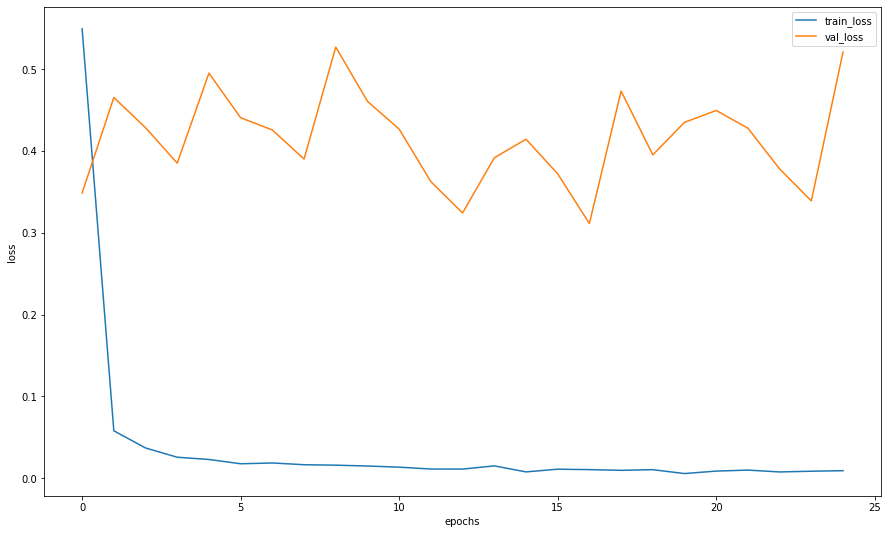

In [20]:
loss, acc, val_loss, val_acc = zip(*hist)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Поведение функции потерь не очень хорошее. Видно, что около половины эпох были безрезультатны, т.е. не дали никаких существенных улучшений.

Это может быть связано со слишком большим leaning rate'ом, либо был достигнут предел возможностей этого набора данных (ведь там много повторяющихся картинок).
Посмотрим на статистику по всей валидационной выборке:

In [21]:
y_pred_val = np.array([], dtype=np.uint8)
actual_labels_val = np.array([], dtype=np.uint8)
for index in range(len(val_dataset)):
    prob_pred = predict_one_sample(model_ft, val_dataset[index][0].unsqueeze(0))
    y_pred_val = np.append(y_pred_val, np.argmax(prob_pred, -1)[0])
    actual_labels_val = np.append(actual_labels_val, val_dataset[index][1])
print(
    classification_report(actual_labels_val, y_pred_val, target_names=class_labels)
)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.93      0.96       228
           agnes_skinner       0.42      1.00      0.59        10
  apu_nahasapeemapetilon       1.00      0.99      1.00       155
           barney_gumble       0.42      0.96      0.58        26
            bart_simpson       0.98      0.96      0.97       335
            carl_carlson       1.00      0.92      0.96        24
charles_montgomery_burns       0.98      0.97      0.98       297
            chief_wiggum       0.89      0.99      0.94       245
         cletus_spuckler       1.00      1.00      1.00        11
          comic_book_guy       0.98      0.97      0.97       116
               disco_stu       1.00      1.00      1.00         2
          edna_krabappel       0.94      0.95      0.94       114
                fat_tony       0.88      1.00      0.93         7
                     gil       0.83      0.71      0.77         7
    groun

Визуально оценим результаты работы сети, для начала на неправильно распознанных картинках:

In [22]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

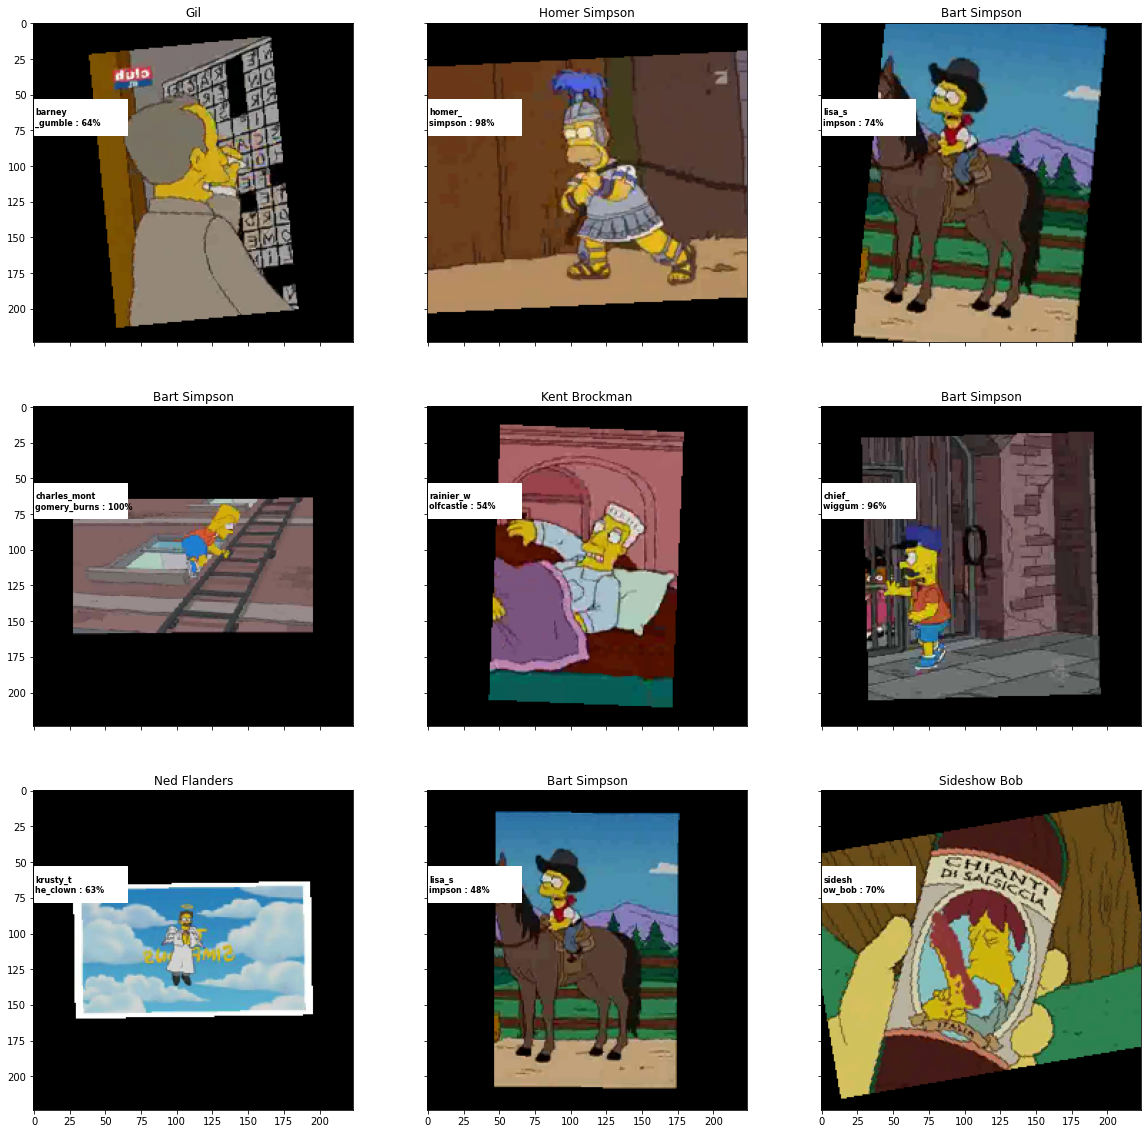

In [23]:
pics = [ind for ind, elem in enumerate(actual_labels_val) if elem != y_pred_val[ind]]
if pics: # ну а вдруг
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_character = int(np.random.uniform(0, len(pics)))
        im_val, label = val_dataset[pics[random_character]]
        img_label = " ".join(
            map(
                lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split("_"),
            )
        )

        imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

        fig_x.add_patch(patches.Rectangle((0, 53), 65, 25, color="white"))
        prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred) * 100
        y_pred = np.argmax(prob_pred)

        predicted_label = label_encoder.classes_[y_pred]
        predicted_label = (
            predicted_label[: len(predicted_label) // 2]
            + "\n"
            + predicted_label[len(predicted_label) // 2 :]
        )
        predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

        fig_x.text(
            1,
            59,
            predicted_text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=8,
            color="black",
            fontweight="bold",
        )

Вполне возможно, что некоторые ранее неправильно распознанные образцы окажутся вдруг правильными. Это связано с тем, что валидационная часть проходит при подгрузке через несколько случайных трансформеров, которые масштабируют и поворачивают изображения. Но в целом, даже если теперь классификация правильная, сеть слабо уверена в своем выборе. Из любопытства поглядим и на хорошие образцы:

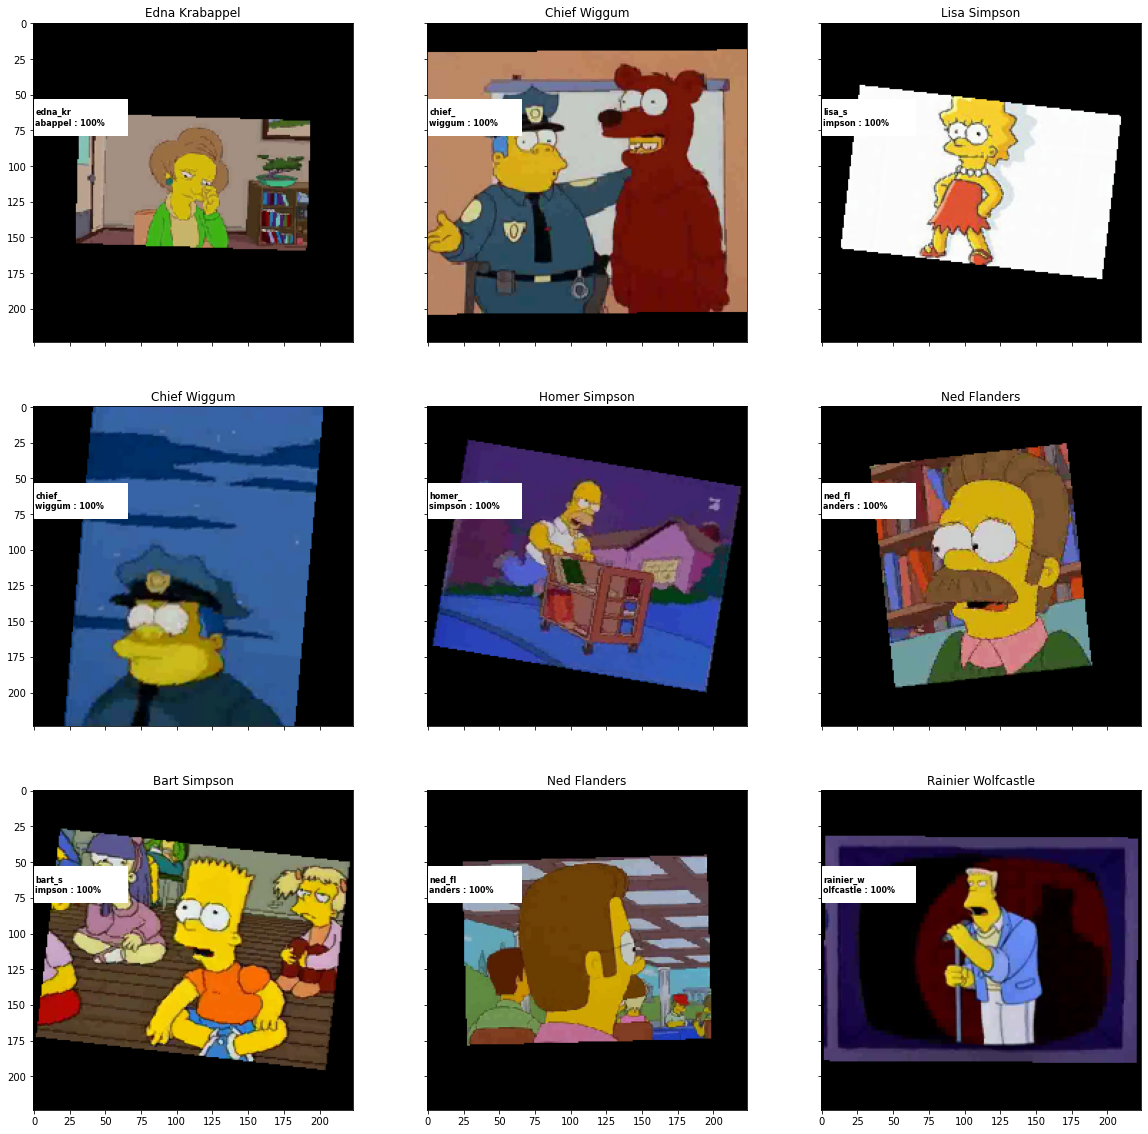

In [24]:
pics = [ind for ind, elem in enumerate(actual_labels_val) if elem == y_pred_val[ind]]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_character = int(np.random.uniform(0, len(pics)))
    im_val, label = val_dataset[pics[random_character]]
    img_label = " ".join(
        map(
            lambda x: x.capitalize(),
            val_dataset.label_encoder.inverse_transform([label])[0].split("_"),
        )
    )

    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

    fig_x.add_patch(patches.Rectangle((0, 53), 65, 25, color="white"))
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = (
        predicted_label[: len(predicted_label) // 2]
        + "\n"
        + predicted_label[len(predicted_label) // 2 :]
    )
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(
        1,
        59,
        predicted_text,
        horizontalalignment="left",
        verticalalignment="top",
        fontsize=8,
        color="black",
        fontweight="bold",
    )

Информация ниже чисто отладочная, связанная с попытками поймать ошибки в обучающих данных.
Некоторые картинки были вручную удалены из датасета, ибо определенно являлись выбросами.


In [25]:
# # Ошибки валидационной части
# indexes = [ind for ind, elem in enumerate(actual_labels_val) if elem != y_pred_val[ind]]
# mistakes = {}
# mistakes["Path"] = [str(val_dataset.files[i]) for i in indexes]
# mistakes["Prediction"] = [class_labels[y_pred_val[i]] for i in indexes]
#
# # Ошибки обучающей части
# y_pred_train = np.array([], dtype=np.uint8)
# actual_labels_train = np.array([], dtype=np.uint8)
# train_debug = SimpsonsDataset(train_files, mode="val")
# for index in range(len(train_debug)):
#     prob_pred = predict_one_sample(model_ft, train_debug[index][0].unsqueeze(0))
#     y_pred_train = np.append(y_pred_train, np.argmax(prob_pred, -1)[0])
#     actual_labels_train = np.append(actual_labels_train, train_debug[index][1])
# indexes = [
#     ind for ind, elem in enumerate(actual_labels_train) if elem != y_pred_train[ind]
# ]
# mistakes["Path"] += [str(train_debug.files[i]) for i in indexes]
# mistakes["Prediction"] += [class_labels[y_pred_train[i]] for i in indexes]
#
# # Сохранить все в отдельную папку для удобного просмотра
# for path in mistakes["Path"]:
#     dest = "debug" + path.split("simpsons_dataset")[1]
#     os.makedirs(os.path.dirname(dest), exist_ok=True)
#     shutil.copyfile(path, dest)
# pd.DataFrame.from_dict(mistakes).to_csv("debug/mistakes.csv", index=False)

## Kaggle

In [26]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ft, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({"Id": test_filenames, "Expected": preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [27]:
my_submit.to_csv("kaggle_submission.csv", index=False)

Предсказания из конкретно этого отчета получили F1-score = 0.973 на кагле.

Касательно воспроизводимости:

Не уверен, что ее вообще можно обеспечить манипуляциями с генераторами случайных чисел без потери качества модели. Кроме того, некоторые файлы были вручную удалены
из тренировочной части, какие именно - не помню.

Но в общем и целом, как показал эксперимент, при перезапуске ноутбука результаты будут похожими по качеству, даже при наличии разного рода случайностей в процессе обучения.